<a href="https://colab.research.google.com/github/julycapstone2020/Pneumonia-Detection-Challenge/blob/development/maskRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug


     |████████████████████████████████| 35.5MB 1.3MB/s 


In [4]:
import os
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa

%matplotlib inline

In [5]:
# load MDI client library
!pip install --upgrade --quiet mdai
import mdai
mdai.__version__

     |████████████████████████████████| 51kB 2.7MB/s 


'0.5.7'

In [6]:
# Root directory of the project
ROOT_DIR = os.path.abspath('./lesson3-data')
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, 'logs')

if not os.path.exists(ROOT_DIR):
    os.makedirs(ROOT_DIR)
os.chdir(ROOT_DIR)

In [7]:
##Install Matterport's Mask-RCNN model from github. (https://github.com/matterport/Mask_RCNN)

!git clone https://github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')
#!pip install -q -r requirements.txt
#!python setup.py -q install


Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 116.77 MiB | 11.31 MiB/s, done.
Resolving deltas: 100% (565/565), done.


In [8]:
from google.colab import drive
drive.mount('/content/gdrive') #, force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [9]:
!ls -la "/content/gdrive/My Drive/"
!pwd
!mv /content/lesson3-data/Mask_RCNN/requirements.txt "/content/gdrive/My Drive/mrcnn/requirements.txt.old1"
!diff "/content/gdrive/My Drive/mrcnn/requirements.txt.old1" "/content/gdrive/My Drive/mrcnn/requirements.txt"
!cp  "/content/gdrive/My Drive/mrcnn/requirements.txt" /content/lesson3-data/Mask_RCNN/
!more /content/lesson3-data/Mask_RCNN/requirements.txt

total 19
drwx------ 2 root root 4096 Jul 29 08:53 'Colab Notebooks'
drwx------ 2 root root 4096 Jul 29 08:49  darknet
drwx------ 2 root root 4096 Aug  4 11:53  mrcnn
-rw------- 1 root root 6256 Aug  1 10:08  PneumoniaDetection-master.zip
/content/lesson3-data/Mask_RCNN
7,8c7,8
< tensorflow>=1.3.0
< keras>=2.0.8
---
> tensorflow==1.9.0
> keras==2.0.8
numpy
scipy
Pillow
cython
matplotlib
scikit-image
tensorflow==1.9.0
keras==2.0.8
opencv-python
h5py
imgaug
IPython[all]


In [10]:
#!more /content/lesson3-data/Mask_RCNN/mrcnn/config.py | grep RPN_ANCHOR_SCALES
#!cp /content/lesson3-data/Mask_RCNN/mrcnn/config.py  "/content/gdrive/My Drive/mrcnn/config.py.old"
#!more "/content/gdrive/My Drive/mrcnn/config.py" | grep RPN_ANCHOR_SCALES
#!mv  /content/lesson3-data/Mask_RCNN/mrcnn/config.py /content/lesson3-data/Mask_RCNN/mrcnn/config.py.old
#!cp  "/content/gdrive/My Drive/mrcnn/config.py" /content/lesson3-data/Mask_RCNN/mrcnn/  
!more /content/lesson3-data/Mask_RCNN/mrcnn/config.py | grep RPN_ANCHOR_SCALES

    RPN_ANCHOR_SCALES = (32, 64, 128, 256, 512)


In [11]:
!pip3 install -r requirements.txt
!python3 setup.py install

     |████████████████████████████████| 51.1MB 80kB/s 
     |████████████████████████████████| 276kB 40.8MB/s 
     |████████████████████████████████| 3.3MB 45.7MB/s 
     |████████████████████████████████| 573kB 42.9MB/s 
     |████████████████████████████████| 163kB 44.8MB/s 
     |████████████████████████████████| 204kB 42.9MB/s 
ERROR: xarray 0.15.1 has requirement setuptools>=41.2, but you'll have setuptools 39.1.0 which is incompatible.
ERROR: textgenrnn 1.4.1 has requirement keras>=2.1.5, but you'll have keras 2.0.8 which is incompatible.
ERROR: google-auth 1.17.2 has requirement setuptools>=40.3.0, but you'll have setuptools 39.1.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninstalled tensorboard-2.3.0
  Found existing installation: setuptools 49.2.0
    Uninstalling setuptools-49.2.0:
 

running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
reading manifest template 'MANIFEST.in'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build
creating build/lib
creating build/lib/mrcnn
copying mrcnn/model.py -> build/lib/mrcnn
copying mrcnn/visualize.py -> build/lib/mrcnn
copying mrcnn/parallel_model.py -> build/lib/mrcnn
copying mrcnn/utils.py -> build/lib/mrcnn
copying mrcnn/config.py -> build/lib/mrcnn
copying mrcnn/__init__.py -> build/lib/mrcnn
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/egg/mrcnn

In [ ]:
#!pwd
#!ls -lt mrcnn/model.py
#!mv mrcnn/model.py "/content/gdrive/My Drive/mrcnn/model.py"
#!cp "/content/gdrive/My Drive/mrcnn/model.py" mrcnn/
#!ls -lt mrcnn/model.py 
#! more mrcnn/model.py | grep keep_dims
#! more mrcnn/model.py | grep keepdims

In [12]:
## NEW
import tensorflow  as tf
import keras as kf
print(tf.__version__)
print(kf.__version__)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or 

1.9.0
2.0.8


In [ ]:
##OLD
#import tensorflow as tf
#import keras as kf
#print(tf.__version__)
#print(kf.__version__)

2.3.0
2.4.3


In [13]:
# Import Mask RCNN
sys.path.append(os.path.join(ROOT_DIR, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log


In [14]:
## Create an mdai client
mdai_client = mdai.Client(domain='public.md.ai', access_token="54588a008e5f0e39c69e294bbc1dbe8f")

Successfully authenticated to public.md.ai.


In [15]:
p = mdai_client.project('LxR6zdR2', path='./lesson3-data')

Using path './lesson3-data' for data.
Preparing annotations export for project LxR6zdR2...                                                
Preparing images export for project LxR6zdR2...                                                     


  0%|          | 0.00/3.18G [00:00<?, ?B/s]
  0%|          | 4.03M/3.18G [00:00<05:46, 9.82MB/s]
 22%|██▏       | 4.03M/18.7M [00:00<00:00, 17.4MB/s]
 43%|████▎     | 8.03M/18.7M [00:00<00:00, 17.6MB/s]
18.7MB [00:00, 30.0MB/s]                            


Success: annotations data for project LxR6zdR2 ready.


3.18GB [00:58, 58.3MB/s]                            


Extracting archive: mdai_public_project_LxR6zdR2_images_2018-08-20-184248.zip
Success: images data for project LxR6zdR2 ready.


In [16]:
# this maps label ids to class ids
labels_dict = {'L_ylR0L8':0, # background 
               'L_DlqEAl':1, # lung opacity 
              }

print(labels_dict)
p.set_labels_dict(labels_dict)
p.show_label_groups()

{'L_ylR0L8': 0, 'L_DlqEAl': 1}
Label Group, Id: G_R28gN5, Name: Default group
	Labels:
	Id: L_ylR0L8, Name: No Lung Opacity
	Id: L_DlqEAl, Name: Lung Opacity



In [18]:
p.show_datasets()

Datasets:
Id: D_ao3XWQ, Name: stage 1 train



In [19]:
dataset = p.get_dataset_by_id('D_ao3XWQ')
dataset.prepare()

In [20]:
dataset.show_classes()

Label id: L_ylR0L8, Class id: 0, Class text: No Lung Opacity
Label id: L_DlqEAl, Class id: 1, Class text: Lung Opacity


In [21]:
anns = dataset.get_annotations()

In [22]:
## Train / test split
train_dataset, valid_dataset = mdai.common_utils.train_test_split(dataset)

Num of instances for training set: 23115, validation set: 2569


In [23]:
anns = dataset.get_annotations(labels_dict.keys(), verbose=True)

Dataset contains 28989 annotations, filtered by label ids dict_keys(['L_ylR0L8', 'L_DlqEAl']).


In [24]:
# These parameters have been changed to reduce run-time per epoch at the expense 
# of training performance

class DetectorConfig(Config):
    """Configuration for training pneumonia detection on the RSNA pneumonia dataset.
    Overrides values in the base Config class.
    """
    NAME = 'pneumonia'
    GPU_COUNT = 1
    IMAGES_PER_GPU = 16 # on aws, use 16
    BACKBONE = 'resnet50'
    NUM_CLASSES = 2  # background + 1 pneumonia classes
    IMAGE_MIN_DIM = 64
    IMAGE_MAX_DIM = 64
    #RPN_ANCHOR_SCALES = (32, 64)
    TRAIN_ROIS_PER_IMAGE = 16
    MAX_GT_INSTANCES = 3
    DETECTION_MAX_INSTANCES = 3
    DETECTION_MIN_CONFIDENCE = 0.9
    DETECTION_NMS_THRESHOLD = 0.1
    POST_NMS_ROIS_TRAINING = 200
    RPN_TRAIN_ANCHORS_PER_IMAGE = 16
    STEPS_PER_EPOCH = 100 
    TOP_DOWN_PYRAMID_SIZE = 32
     
config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     16
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 16
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  64
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  64
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [64 64  3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                   

In [25]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training pneumonia detection on the RSNA pneumonia dataset.
    """

    def __init__(self, source_name, dataset, orig_height, orig_width):
        super().__init__(self)
        
        # add classes 
        for k, v in dataset.classes_dict.items():
            if v['class_id'] is not 0: 
                self.add_class(source_name, v['class_id'], v['class_text'])

        # add images 
        img_ids = dataset.get_image_ids()
        imgs_anns_dict = dataset.imgs_anns_dict
        
        #########################################################
        # WARNING: Using only the first 1000 images to reduce 
        #          run-time for demonstration only 
        # To run all images, do: for i, fp in enumerate(img_ids):
        #########################################################
        for i, fp in enumerate(img_ids[:1000]):
            annotations = imgs_anns_dict[fp]
            self.add_image(source_name, image_id=i, path=fp, 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        ds = pydicom.read_file(
            fp)
        image = ds.pixel_array
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            assert(dataset.label_id_to_class_id(a['labelId']) == 0)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                if a['data'] is not None:
                    x = int(a['data']['x'])
                    y = int(a['data']['y'])
                    w = int(a['data']['width'])
                    h = int(a['data']['height'])
                    mask_instance = mask[:, :, i].copy()
                    cv2.rectangle(mask_instance, (x, y), (x+w, y+h), 255, -1)
                    mask[:, :, i] = mask_instance
                    class_ids[i] = dataset.label_id_to_class_id(a['labelId'])
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [41]:
# Training dataset
source_name = 'pneumonia'
dataset_train = DetectorDataset(source_name, train_dataset, 1024, 1024)
dataset_train.prepare()

# Validation dataset
dataset_val = DetectorDataset(source_name, valid_dataset, 1024, 1024)
dataset_val.prepare()

(-0.5, 1023.5, 1023.5, -0.5)

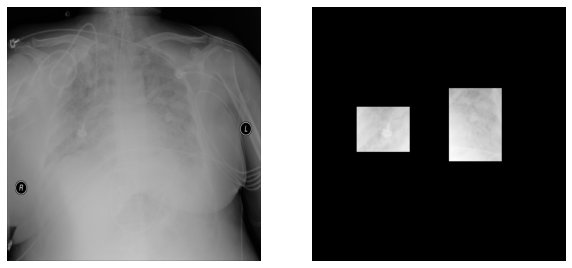

In [27]:
##Display a few images

# Load and display random samples
image_id = 22 #random.choice(dataset_train.image_ids)
image = dataset_train.load_image(image_id)
#image = dataset_train.load_image(78)
mask, class_ids = dataset_train.load_mask(image_id)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(image[:, :, 0], cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += image[:, :, 0] * mask[:, :, i]
plt.imshow(masked, cmap='gray')
plt.axis('off')

In [43]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=MODEL_DIR)
augmentation = iaa.SomeOf((0, 1), [
    iaa.Fliplr(0.5),
    iaa.Affine(
        scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
        translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
        rotate=(-25, 25),
        shear=(-8, 8)
    ),
    iaa.Multiply((0.9, 1.1))
])

In [45]:
! pwd
! ls -lt /content/lesson3-data/logs/*
! mv /content/lesson3-data/logs/*  "/content/gdrive/My Drive/mrcnn/"
! ls -lt  "/content/gdrive/My Drive/mrcnn/"

/content/lesson3-data/Mask_RCNN
ls: cannot access '/content/lesson3-data/logs/*': No such file or directory
mv: cannot stat '/content/lesson3-data/logs/*': No such file or directory
total 1604
drwx------+ 2 root root    4096 Aug  5 08:53 pneumonia20200805T0743
-rw-------+ 1 root root     119 Aug  5 07:37 requirements.txt.old1
-rw-------  1 root root     119 Aug  4 17:44 requirements.txt
-rw-------  1 root root    9396 Aug  4 16:41 config.py.old
-rw-------  1 root root    9397 Aug  4 16:40 config.py
-rw-------  1 root root  126960 Aug  4 15:32 model.py
-rw-------  1 root root     119 Aug  4 15:09 requirements.txt.old
-rw-------  1 root root 1490034 Dec 11  2019 stage_2_train_labels.csv


In [46]:
NUM_EPOCHS = 3

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=NUM_EPOCHS, 
            #augmentation=augmentation, # uncomment to enable augmentation
            layers='all')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/lesson3-data/logs/pneumonia20200805T0924/mask_rcnn_pneumonia_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
bn3a

Evaluate model on few random images

In [47]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))
    
fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else: 
      
      checkpoint = os.path.join(dir_name, checkpoints[-1])
      fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

Found model /content/lesson3-data/logs/pneumonia20200805T0924/mask_rcnn_pneumonia_0002.h5


In [48]:

class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
inference_config.display()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        3
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.1
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  64
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  64
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [64 64  3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                     

In [52]:
def show_randoms(dataset):
    fig = plt.figure(figsize=(10,20))

    num_imgs = 12
    for i in range(num_imgs):

        image_id = random.choice(dataset.image_ids)
        original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, inference_config, 
                                   image_id, use_mini_mask=False)
     
        plt.subplot(num_imgs, 2, 2*i + 1)
        visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                    dataset.class_names,
                                    colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
        plt.title('Ground Truth')
        
        plt.subplot(num_imgs, 2, 2*i + 2)
        
        # turn off verbose if you don't want debug messages 
        results = model.detect([original_image],verbose=1)
        r = results[0]
        visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                    dataset.class_names, r['scores'], 
                                    colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])
        plt.title('Prediction')

In [53]:
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors


*** No instances to display *** 

Processing 1 images
image                    shape: (64, 64, 3)           min:    0.00000  max:  244.00000  uint8
molded_images            shape: (1, 64, 64, 3)        min: -123.70000  max:  140.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:   64.00000  int64
anchors                  shape: (1, 1023, 4)          min:   -5.74665  max:    5.73077  float32

*** No instances to display *** 

Processing 1 images
image                    shape: (64, 64, 3)           min:    0.00000  max:  239.00000  uint8
molded_images            shape: (1, 64, 64, 3)        min: -123.70000  max:  135.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:   64.00000  int64
anchors                  shape: (1, 1023, 4)          min:   -5.74665  max:    5.73077  float32

*** No instances to display *** 

Processing 1 images
image                    shape: (64, 64, 3)           min:    7.00000  max:

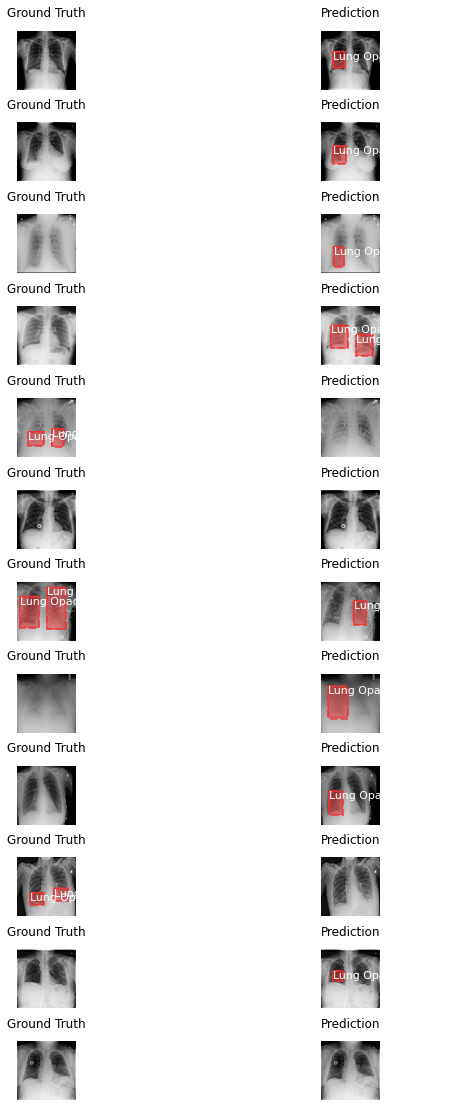

In [54]:
show_randoms(dataset_val)